In [1]:
import plumed
import numpy as np
import pandas as pd
import MDAnalysis as mda
import nglview
import os
from pathlib import Path
from psfgen import PsfGen
import subprocess
import gromacs
import panedr
from gromacs.setup import *

import matplotlib.pyplot as plt

import yaml



[dgx-master.technion.ac.il:3385968] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3385968] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


In [2]:
base  = Path(os.getcwd()).parent

In [3]:
import sys
extra_path = str(base / 'src' )

In [4]:
if extra_path not in sys.path:
    sys.path.append(extra_path)
    
from utils import clean, run_omp_slurm, run_mpi_slurm

In [5]:
# set some general constants
NSTEPS = 1000000
NSTXOUT = 100
TEMPERATURE = 340
NSTENERGY=100

# set timers to strech and posres runs

nsteps_strech = 100000
nsteps_posres = 100000


# YYDPETGTWY -> YYDPESGTWY
# set some mutation and file/folder names 

mutate = [('5','SER')]

mutate_name = 'YYDPESGTWY'


## Simulate the starting position for chignolin

## Folded state

In [6]:
# create pdb psf files

gen = PsfGen(output="/dev/null")  # Suppress output since there's too much
#gen.read_topology('../data/top_all27_prot_lipid_na.inp')
gen.read_topology(str(base / 'data/top_all27_prot_lipid_na.inp'))

In [7]:
gen.alias_atom(resname='ILE' , top_atomname='CD', pdb_atomname='CD1')
gen.add_segment(segid="P",
                pdbfile=str(base / 'data/YYDPETGTWY.pdb'),
                first='NTER',
                last='CTER',
                mutate= mutate
                )
gen.read_coords(segid="P", filename=str(base / 'data/YYDPETGTWY.pdb'))
gen.regenerate_resids()
gen.regenerate_angles()
gen.regenerate_dihedrals()
gen.guess_coords()

In [8]:
# make folder
fdir = base / 'data/interim' / mutate_name / 'state_folded'

In [9]:
os.makedirs(str(fdir), exist_ok=True)

In [10]:
gen.write_pdb(str(fdir / str(mutate_name + '.pdb')))
gen.write_psf(str(fdir / str(mutate_name + '.psf')))

In [11]:
# solvate and ionize 
os.chdir(fdir)

In [12]:
# original topology ff 
f1 = topology(protein='protein_solvate', struct= mutate_name + '.pdb',  ff='charmm27', water='tip3p', ignh=True, posrefc=50)
# solvate and ionize
f2 = solvate(boxtype='cubic',distance=1.0, water='tip3p', **f1)

               :-) GROMACS - gmx pdb2gmx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders


Using the Charmm27 force field in directory charmm27.ff

going to rename charmm27.ff/aminoacids.r2b
going to rename charmm27.ff/rna.r2b
Reading /rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/YYDPESGTWY.pdb...
Read '', 92 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 10 residues with 92 atoms

  chain  #res #atoms
  1 'A'    10     92  

Reading residue database... (Charmm27)
Processing chain 1 'A' (92 atoms, 10 residues)
Identified residue TYR0 as a starting terminus.
Identified residue TYR9 as a ending terminus.
Start terminus TYR-0: NH3+
End terminus TYR-9: COO-
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 10 residues with 163 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: /rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/YYDPESGTWY.

[dgx-master.technion.ac.il:3386946] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3386946] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
              :-) GROMACS - gmx editconf, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Sh

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 163 atoms
No velocities found
    system size :  1.619  1.509  1.306 (nm)
    diameter    :  1.784               (nm)
    center      :  0.017 -0.513 -0.638 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  1.875  2.405  2.530 (nm)
new center      :  1.892  1.892  1.892 (nm)
new box vectors :  3.784  3.784  3.784 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  54.18               (nm^3)


[dgx-master.technion.ac.il:3386971] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3386971] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3386971] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
               :-) GROMACS - gmx solvate, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu M


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Adding line for 1647 solvent molecules with resname (SOL) to topology file (/rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/top/system.top)


Removed 1815 solvent atoms due to solvent-solvent overlap
Removed 165 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms):  1647 residues
Generated solvent containing 4941 atoms in 1647 residues
Writing generated configuration to solvated.gro

Output configuration contains 5104 atoms in 1657 residues
Volume                 :     54.1753 (nm^3)
Density                :     950.745 (g/l)
Number of solvent molecules:   1647   

Processing topology

Back Off! I just backed up /rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/top/system.top to /rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/top/#system.top.1#

GROMACS reminds you: "I invented the term 'Object-Oriented', and I can tell you I did not have C++ in mind." (Alay Kay, author of Smalltalk)

[dgx-master.technion.ac.il:3387004] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387004] PM

Will try to add 2 NA ions and 0 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 2 solute molecules in topology file (/rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/top/system.top)  by 2 NA and 0 CL ions.


              :-) GROMACS - gmx make_ndx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 18: '__main__'
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders

In [13]:
# minimize rigid
f3 = energy_minimize(integrator='steep',maxwarn=10, **f2)

[dgx-master.technion.ac.il:3387163] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387163] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
/home/zadoki/miniconda3/envs/gromacs_plumed/lib/python3.9/site-packages/gromacs/setup.py:781: UsageWarning: Unprocessed mdp option are interpreted as options for grompp:
{'maxwarn': 10, 'pp': 'processed.top'}
  warnings.warn(wmsg, category=UsageWarning)
               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carste

Analysing residue names:
There are:    10    Protein residues
There are:  1645      Water residues
There are:     2        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.118 0.118 0.118
This run will generate roughly 0 Mb of data


[dgx-master.technion.ac.il:3387185] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387185] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
/home/zadoki/miniconda3/envs/gromacs_plumed/lib/python3.9/site-packages/gromacs/run.py:445: AutoCorrectionWarning: No 'mdrun_d' binary found so trying 'mdrun' instead.
(Note that energy minimization runs better with mdrun_d.)
  warnings.warn(wmsg, category=AutoCorrectionWarning)
                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson    

In [14]:
# restrained md npt 20ns
MD_restrained(r=str(fdir / 'em/em.pdb') , maxwarn=10, nstxout=NSTXOUT, nstvout=0, nstenergy=NSTENERGY, nstxtcout = 0, nsteps= nsteps_posres, **f3)

[dgx-master.technion.ac.il:3387214] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387214] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387214] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
              :-) GROMACS - gmx make_ndx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu M

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.008 nm, buffer size 0.008 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.118 0.118 0.118
This run will generate roughly 60 Mb of data


[dgx-master.technion.ac.il:3387357] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387357] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3387357] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


{'struct': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/MD_POSRES/md.gro',
 'top': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/top/system.top',
 'ndx': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/MD_POSRES/md.ndx',
 'qscript': ['./local.sh'],
 'mainselection': '"Protein"',
 'deffnm': 'md',
 'r': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/YYDPESGTWY/state_folded/em/em.pdb',
 'maxwarn': 10,
 'nstxout': 100,
 'nstvout': 0,
 'nstenergy': 100,
 'nstxtcout': 0,
 'nsteps': 100000,
 'nstfout': '0',
 'nstlog': '500'}

In [15]:
os.chdir(fdir / 'MD_POSRES')

In [16]:
subprocess.run('gmx_mpi mdrun  -v -deffnm md  -ntomp 8 ', shell=True )

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

CompletedProcess(args='gmx_mpi mdrun  -v -deffnm md  -ntomp 8 ', returncode=0)

[dgx-master:2734797] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master:2734797] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


In [17]:
os.chdir(fdir)

In [18]:
MD(r=str(fdir / 'MD_POSRES/md.tpr') , maxwarn=10, nstxout=NSTXOUT, nstvout=0, nstenergy=NSTENERGY, nstxtcout = 0, nsteps= NSTEPS, **f3)

              :-) GROMACS - gmx make_ndx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.008 nm, buffer size 0.008 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.118 0.118 0.118
This run will generate roughly 1 Mb of data


{'struct': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_folded/MD/md.gro',
 'top': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_folded/top/system.top',
 'ndx': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_folded/MD/md.ndx',
 'qscript': ['./local.sh'],
 'mainselection': '"Protein"',
 'deffnm': 'md',
 'r': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_folded/MD_POSRES/md.tpr',
 'maxwarn': 10,
 'nstxout': 100,
 'nstvout': 0,
 'nstenergy': 100,
 'nstxtcout': 0,
 'nsteps': 1000}

##  make reference pdb for plumed - align on protein backbone

In [19]:

# load traj
u = mda.Universe(fdir / 'MD_POSRES/md.tpr', fdir / 'MD_POSRES/md.trr' )

u.add_TopologyAttr('tempfactors')
u.add_TopologyAttr('occupancy')

# Select protein
p = u.select_atoms('protein')

u.trajectory[-1]

# set attributes for RMSD and reference
bb = p.select_atoms('backbone')


bb.atoms.tempfactors = 1 
bb.atoms.occupancies  =  1 

# change some oxygen names

p.select_atoms('name OT1').atoms.names = 'O'
p.select_atoms('name OT2').atoms.names = 'OXT'
#[atomselect top "name OT1"] set name O
#[atomselect top "name OT2"] set name OXT



# fix zero based resids
p.residues.resids = p.residues.resids -1 

# save pdb

p.write(fdir / 'reference.pdb', bonds = None )

[dgx-master:2735874] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master:2735874] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
/home/zadoki/miniconda3/envs/gromacs_plumed/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/zadoki/miniconda3/envs/gromacs_plumed/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/zadoki/miniconda3/envs/gromacs_plumed/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'record_types' Using default value of 'ATOM'
  warnings.warn("Found no information for attr: '{}'"
/home/zadoki/miniconda3/envs/gromacs_plumed/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.p

In [20]:
os.chdir(fdir / 'MD')
shutil.copy2(fdir/ 'reference.pdb', 'reference.pdb')

'reference.pdb'

In [21]:
# write plumed cv collection file
with open('plumed.dat', 'w') as f:
    print("""
    # vim:ft=plumed
    # calculate  CVs for HLDA 
    MOLINFO STRUCTURE=reference.pdb MOLTYPE=protein
    WHOLEMOLECULES RESIDUES=all MOLTYPE=protein
    rmsd: RMSD REFERENCE=reference.pdb TYPE=OPTIMAL NOPBC
    e2e: DISTANCE ATOMS=@N-0,@O-9 NOPBC
    rg: GYRATION TYPE=RADIUS ATOMS=@back-0,@back-1,@back-2,@back-3,@back-4,@back-5,@back-6,@back-7,@back-8,@back-9 NOPBC

    # dihedrals
    psi0: TORSION ATOMS=@psi-0 NOPBC
    phi1: TORSION ATOMS=@phi-1 NOPBC
    psi1: TORSION ATOMS=@psi-1 NOPBC
    phi2: TORSION ATOMS=@phi-2 NOPBC
    psi2: TORSION ATOMS=@psi-2 NOPBC
    phi3: TORSION ATOMS=@phi-3 NOPBC
    psi3: TORSION ATOMS=@psi-3 NOPBC
    phi4: TORSION ATOMS=@phi-4 NOPBC
    psi4: TORSION ATOMS=@psi-4 NOPBC
    phi5: TORSION ATOMS=@phi-5 NOPBC
    psi5: TORSION ATOMS=@psi-5 NOPBC
    phi6: TORSION ATOMS=@phi-6 NOPBC
    psi6: TORSION ATOMS=@psi-6 NOPBC
    phi7: TORSION ATOMS=@phi-7 NOPBC
    psi7: TORSION ATOMS=@psi-7 NOPBC
    phi8: TORSION ATOMS=@phi-8 NOPBC
    psi8: TORSION ATOMS=@psi-8 NOPBC
    phi9: TORSION ATOMS=@phi-9 NOPBC

    
    PRINT ...
    ARG=rmsd,e2e,rg,psi0,phi1,psi1,phi2,psi2,phi3,psi3,phi4,psi4,phi5,psi5,phi6,psi6,phi7,psi7,phi8,psi8,phi9
    FILE=COLVAR STRIDE=100
    ... PRINT
    """, file = f) 

In [22]:
subprocess.run('gmx_mpi mdrun  -v -deffnm md -cpi -plumed plumed.dat  -c md.pdb -ntomp 8 -nsteps {} '.format(NSTEPS), shell=True )

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

CompletedProcess(args='gmx_mpi mdrun  -v -deffnm md -cpi -plumed plumed.dat  -c md.pdb -ntomp 8 -nsteps 1000 ', returncode=0)

In [23]:
data = panedr.edr_to_df(str(fdir / 'MD/md.edr'))

[dgx-master:2735909] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master:2735909] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master:2735909] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


<Axes: xlabel='Time'>

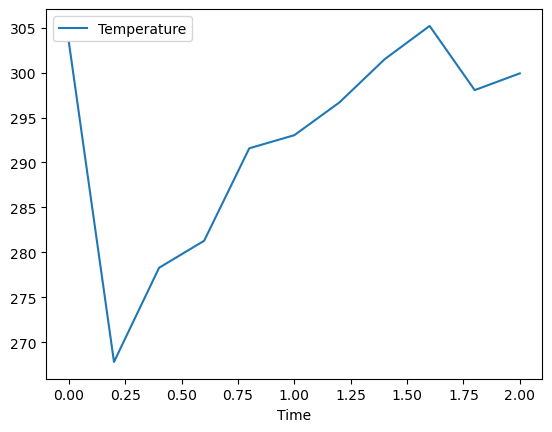

In [24]:

data.iloc[:,:].plot(x='Time', y='Temperature')




<Axes: xlabel='Time'>

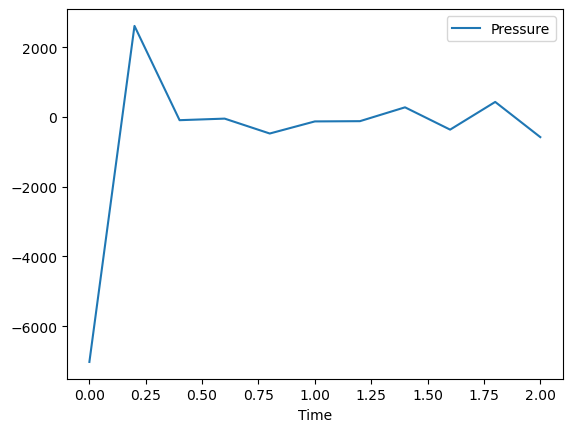

In [25]:
data.iloc[:,:].plot(x='Time', y='Pressure')


<Axes: xlabel='Time'>

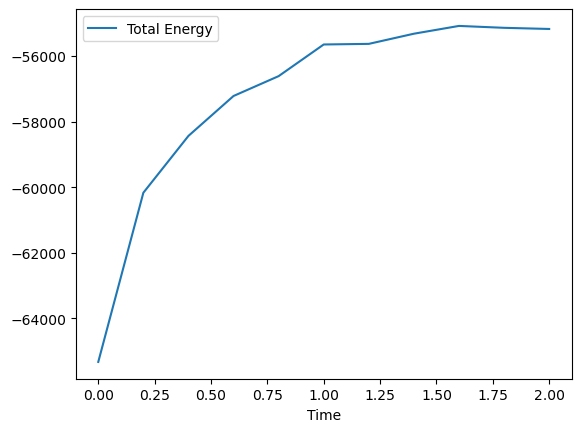

In [26]:
data.iloc[:,:].plot(x='Time', y='Total Energy')


<Axes: xlabel='Time'>

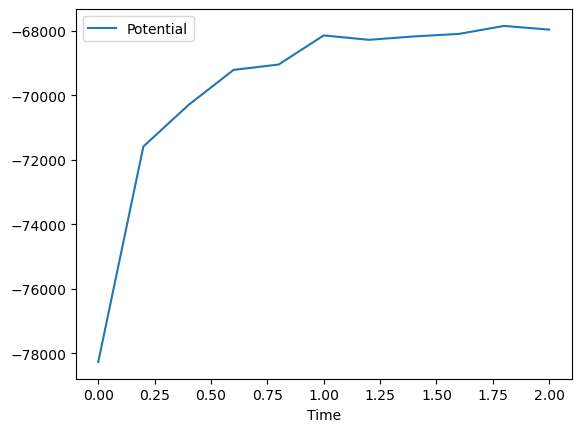

In [27]:
data.iloc[:,:].plot(x='Time', y='Potential')


In [28]:
data.columns

Index(['Time', 'Bond', 'U-B', 'Proper Dih.', 'Improper Dih.', 'CMAP Dih.',
       'LJ-14', 'Coulomb-14', 'LJ (SR)', 'Disper. corr.', 'Coulomb (SR)',
       'Coul. recip.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pres. DC', 'Pressure', 'Constr. rmsd',
       'Box-X', 'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy',
       'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX',
       'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX',
       'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Box-Vel-XX', 'Box-Vel-YY', 'Box-Vel-ZZ', 'T-System', 'Lamb-System'],
      dtype='object')

In [29]:
# bootstrapping averages for convergence
dd = data["Potential"].to_numpy()
length = dd.shape[0]
num_points = 1000
num_straps = 10000
bootstraps = np.zeros(num_straps)

for i in range(num_straps) : 
    av = 0
    av2 = 0 
    for j in range(num_points) : av = av + dd[np.random.randint(0,length)]
    
    bootstraps[i] = (av / num_points)
 


In [30]:
bootstraps.mean(), bootstraps.var()

(-69725.62319192421, 8512.261392455557)

## Unfold protein

In [31]:
ufdir = base / 'data/interim' / mutate_name / 'state_unfolded'
os.makedirs(str(ufdir), exist_ok=True)
os.chdir(ufdir)

In [32]:
os.getcwd()

'/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_unfolded'

In [33]:
# copy some files
MD(r=str(fdir / 'MD_POSRES/md.tpr') , maxwarn=10, nstxout=NSTXOUT, nstvout=0, nstenergy=NSTENERGY, nstxtcout = 0, nsteps= nsteps_strech, **f3)

              :-) GROMACS - gmx make_ndx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.008 nm, buffer size 0.008 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 32x32x32, spacing 0.118 0.118 0.118
This run will generate roughly 6 Mb of data


Velocities were taken from a Maxwell distribution at 300 K
Number of degrees of freedom in T-Coupling group System is 10262.00
Estimate for the relative computational load of the PME mesh part: 0.19

There was 1 note

There was 1 warning

GROMACS reminds you: "Let's Go Hang Out In a Mall" (LIVE)

[dgx-master:2742094] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237


{'struct': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_unfolded/MD/md.gro',
 'top': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_folded/top/system.top',
 'ndx': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_unfolded/MD/md.ndx',
 'qscript': ['./local.sh'],
 'mainselection': '"Protein"',
 'deffnm': 'md',
 'r': '/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_folded/MD_POSRES/md.tpr',
 'maxwarn': 10,
 'nstxout': 100,
 'nstvout': 0,
 'nstenergy': 100,
 'nstxtcout': 0,
 'nsteps': 10000}

[dgx-master:2742094] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


# write plumed strech file

In [34]:
shutil.copy2(fdir/ 'reference.pdb', ufdir/ 'reference.pdb')

PosixPath('/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_unfolded/reference.pdb')

In [35]:
# use plumed to strech protein
with open(ufdir / "MD/plumed_strech.dat","w") as f:
    print("""# vim:ft=plumed
# add a restraint to strech the protein into unfolded state
MOLINFO STRUCTURE={}.pdb MOLTYPE=protein
WHOLEMOLECULES RESIDUES=all MOLTYPE=protein
rmsd: RMSD REFERENCE={}.pdb TYPE=OPTIMAL NOPBC
e2e: DISTANCE ATOMS=@N-0,@C-9 NOPBC
res: RESTRAINT ARG=e2e KAPPA=100 AT=2.5
PRINT ARG=e2e,rmsd,res.bias FILE=COLVAR_STRECH STRIDE=10
     """.format('reference','reference'),file=f)

In [36]:
shutil.copy2(fdir/ 'reference.pdb', ufdir/ 'MD/reference.pdb')
shutil.copy2(fdir/ 'MD/plumed.dat', ufdir/ 'MD/plumed.dat')

PosixPath('/rg/mendels_prj/zadoki/chignolin_test/data/interim/GYDPENGTWG/state_unfolded/MD/plumed.dat')

In [37]:
os.chdir(ufdir/'MD')

In [38]:
clean()

CompletedProcess(args='rm -f \\#*; rm -fr bck.*', returncode=0)


In [39]:
# Strech protein 

subprocess.run('gmx_mpi mdrun  -v -deffnm md -plumed plumed_strech.dat  -c md.pdb -ntomp 8 ', shell=True )

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

CompletedProcess(args='gmx_mpi mdrun  -v -deffnm md -plumed plumed_strech.dat  -c md.pdb -ntomp 8 ', returncode=0)

[dgx-master:2742215] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master:2742215] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniconda3/envs/gromacs_plumed/lib/libplumedKernel.so" +++


<Axes: xlabel='time'>

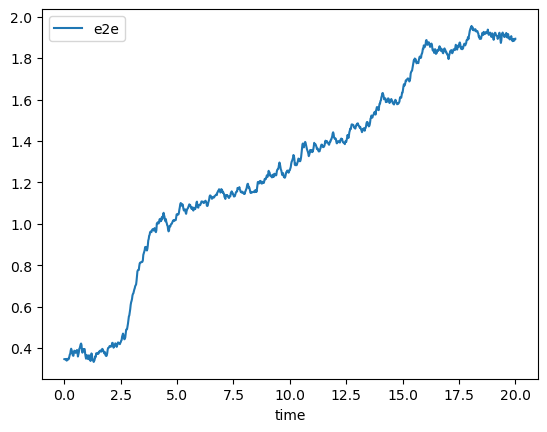

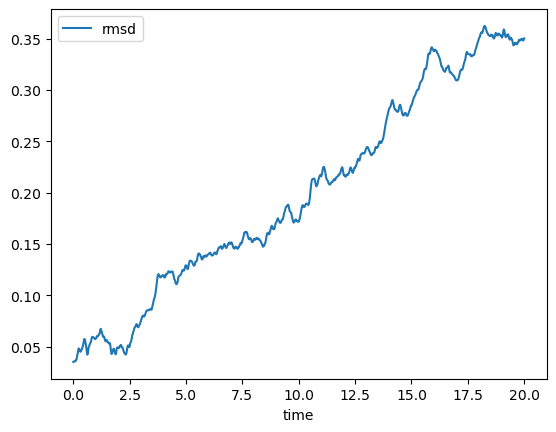

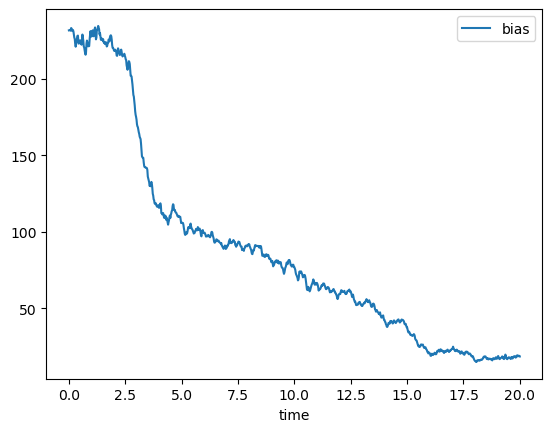

In [40]:
data = plumed.read_as_pandas('COLVAR_STRECH')

data.plot('time','e2e', label='e2e')
data.plot('time','rmsd', label='rmsd')
data.plot('time','res.bias', label='bias')

In [41]:
# simulate and collect CVs


subprocess.run('gmx_mpi mdrun  -v -deffnm md -cpi  -plumed plumed.dat -nsteps {} -c md.pdb -ntomp 8'.format(NSTEPS), shell=True )

                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

CompletedProcess(args='gmx_mpi mdrun  -v -deffnm md -cpi  -plumed plumed.dat -nsteps 1000 -c md.pdb -ntomp 8', returncode=0)

## visualize with nglview

In [42]:
os.chdir(ufdir/ 'MD')

u = mda.Universe('md.tpr', 'md.trr')

[dgx-master:2748703] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master:2748703] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


In [43]:
u.trajectory.n_frames

u.universe.residues[1000]

prot = u.select_atoms("(protein and not type H) or (resname SOL within 2)")

prot

<AtomGroup with 5079 atoms>

In [44]:
view = nglview.show_mdanalysis(prot)
view

NGLWidget(max_frame=110)

# Calculate HLDA CV

## Let's see the states first

In [45]:
from harmonic_discriminant_analysis import HarmonicLinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

In [46]:
data = pd.concat([
    (plumed.read_as_pandas(str(fdir / 'MD/COLVAR'))).assign(state = 'folded'),
    (plumed.read_as_pandas(str(ufdir / 'MD/COLVAR'))).assign(state = 'unfolded')]).reset_index(drop=True)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniconda3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniconda3/envs/gromacs_plumed/lib/libplumedKernel.so" +++


<Axes: xlabel='time'>

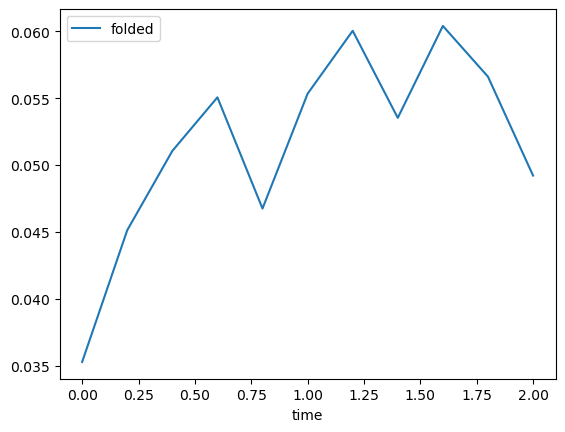

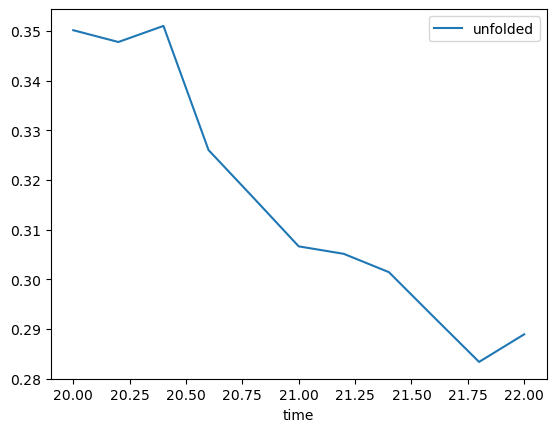

In [47]:
data[data.state == 'folded'].plot('time','rmsd', label = 'folded')
data[data.state == 'unfolded'].plot('time','rmsd', label = 'unfolded')

<Axes: xlabel='time'>

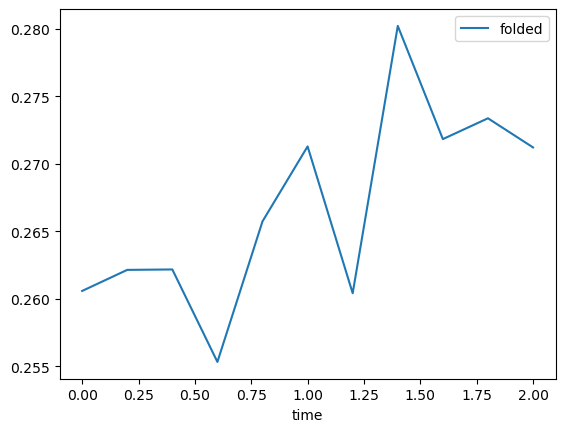

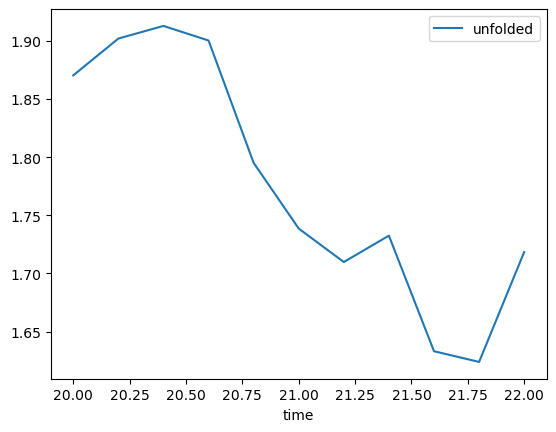

In [48]:
data[data.state == 'folded'].plot('time','e2e', label = 'folded')
data[data.state == 'unfolded'].plot('time','e2e', label = 'unfolded')

<Axes: xlabel='e2e', ylabel='rmsd'>

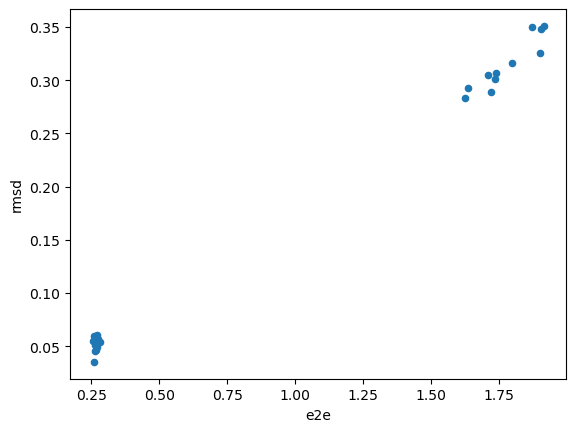

In [49]:
data.plot('e2e','rmsd', kind='scatter')

In [50]:
X = data.iloc[:,data.columns.str.contains('^p')].copy(deep=True)
y = data.state

# apply unwrap 
X = X.apply(np.unwrap,)


In [51]:
hlda = HarmonicLinearDiscriminantAnalysis()

In [52]:
hlda.fit(X,y)

HarmonicLinearDiscriminantAnalysis()

## Plot State separation

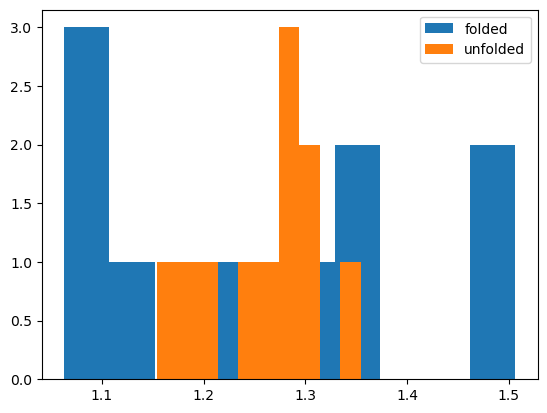

In [53]:
plt.hist(hlda.transform(X)[y == 'folded'],  label = 'folded' )
plt.hist(hlda.transform(X)[y == 'unfolded'], label = 'unfolded' )
plt.legend()
plt.show()

In [54]:
hlda_evects = (hlda.scalings_)[:,0]

## Plot HLDA coefficients

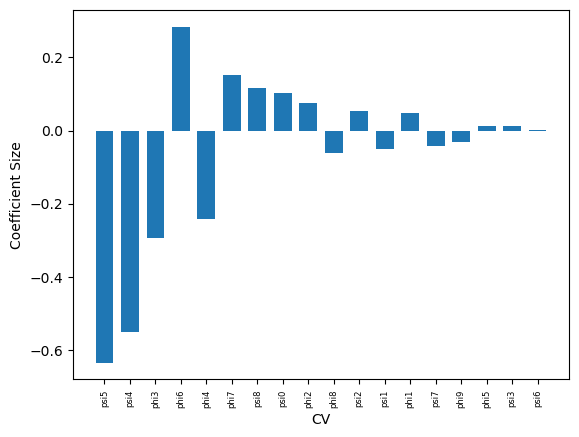

In [55]:
fig = plt.figure()
sortx = np.argsort(np.abs(hlda_evects.flatten()),)[::-1]
plt.bar(X.columns[sortx],hlda_evects.flatten()[sortx],align='center', width=0.7)
plt.xticks(rotation=90,fontsize=6)
plt.xlabel('CV')
plt.ylabel('Coefficient Size')
plt.show()